In [16]:
from keras.datasets import mnist
import numpy as np

In [17]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [18]:
X7_train = X_train[y_train==7]

In [19]:
X7_test = X_test[y_test==7]

In [20]:
X7_train = X7_train/255
X7_test = X7_test/255

In [21]:
X7_train = X7_train[:,:,:,np.newaxis]
X7_test = X7_test[:,:,:,np.newaxis]

In [22]:
X7_train.shape, X7_test.shape

((6265, 28, 28, 1), (1028, 28, 28, 1))

In [23]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, \
    Flatten, Reshape, LeakyReLU, BatchNormalization, Activation
from keras.optimizers import RMSprop

In [24]:
input = Input((28,28,1))
x = LeakyReLU(alpha=0.2)(input)

x = Conv2D(32, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(64, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(128, (5,5), strides=2, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(256, (5,5), strides=1, padding='same')(x)

x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(input, x)
discriminator.summary()




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         2

In [25]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=2e-4, decay=6e-8), metrics=['acc'])
    # decay 값이 클수록 새롭게(처음으로) 변경되는 가중치를 많이 변화시킨다 (디폴트:0)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
input2 = Input((100,)) # 생성벡터는 100차원

x2 = Dense(7*7*128)(input2) # 랜덤 이미지가 입력됨

x2 = Reshape((7,7,128))(x2)

x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(128, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(64, (5,5), strides=2, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(32, (5,5), strides=1, padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = Conv2DTranspose(1, (5,5), strides=1, padding='same')(x2)
x2 = Activation('sigmoid')(x2)

generator = Model(input2, x2)
generator.summary()



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       51

In [27]:
discriminator.trainable = False # 모델들을 연결하여 새로운 모델을 만들 때만 적용된다

adversarial = Model(input2, discriminator(generator(input2)))
adversarial.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         1301505   
_________________________________________________________________
model_1 (Model)              (None, 1)                 1080577   
Total params: 2,382,082
Trainable params: 1,300,801
Non-trainable params: 1,081,281
_________________________________________________________________


In [28]:
adversarial.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=2e-4*0.5, decay=6e-8*0.5), metrics=['acc'])

In [31]:
from keras.preprocessing import image

batch_size = 64
logs = []

for step in range(1000): 
    idx = np.random.randint(0, len(X7_train), size=batch_size)
    real_images = X7_train[idx]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    fake_images = generator.predict(gen_vectors)
    
    X = np.r_[real_images, fake_images] # [batch_size*2,32,32,1]
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch(X, y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    ###########
    a_loss, a_acc = adversarial.train_on_batch(gen_vectors_2, np.ones([batch_size,1]))
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, [%.3f, %.3f, %.3f, %.3f]' % (step+1,d_loss,d_acc,a_loss,a_acc))
    
    if (step+1)%10 == 0:
        adversarial.save_weights('gan_mnist.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        img.save('gan_images/fake_'+str(step)+'.png')

Step: 00001, [0.025, 1.000, 3.019, 0.000]
Step: 00002, [0.019, 1.000, 3.080, 0.000]
Step: 00003, [0.027, 0.992, 2.833, 0.000]
Step: 00004, [0.020, 1.000, 2.946, 0.000]
Step: 00005, [0.016, 1.000, 2.556, 0.000]
Step: 00006, [0.011, 1.000, 2.257, 0.000]
Step: 00007, [0.010, 1.000, 3.011, 0.000]
Step: 00008, [0.008, 1.000, 2.475, 0.000]
Step: 00009, [0.012, 1.000, 2.921, 0.000]
Step: 00010, [0.025, 1.000, 6.372, 0.000]
Step: 00011, [0.077, 0.977, 1.009, 0.156]
Step: 00012, [0.838, 0.508, 9.099, 0.000]
Step: 00013, [0.297, 0.867, 5.399, 0.000]
Step: 00014, [0.042, 0.992, 4.948, 0.000]
Step: 00015, [0.032, 1.000, 4.725, 0.000]
Step: 00016, [0.034, 1.000, 4.652, 0.000]
Step: 00017, [0.040, 0.992, 4.457, 0.000]
Step: 00018, [0.033, 1.000, 4.474, 0.000]
Step: 00019, [0.063, 0.984, 4.240, 0.000]
Step: 00020, [0.054, 0.992, 4.211, 0.000]
Step: 00021, [0.043, 1.000, 4.534, 0.000]
Step: 00022, [0.049, 1.000, 4.685, 0.000]
Step: 00023, [0.039, 1.000, 4.841, 0.000]
Step: 00024, [0.032, 1.000, 4.873,

Step: 00197, [0.611, 0.586, 0.580, 0.781]
Step: 00198, [0.639, 0.531, 1.860, 0.000]
Step: 00199, [0.602, 0.594, 0.569, 0.828]
Step: 00200, [0.627, 0.555, 1.666, 0.000]
Step: 00201, [0.612, 0.641, 0.598, 0.719]
Step: 00202, [0.569, 0.633, 1.230, 0.000]
Step: 00203, [0.554, 0.734, 0.637, 0.688]
Step: 00204, [0.612, 0.609, 1.239, 0.000]
Step: 00205, [0.606, 0.664, 0.601, 0.750]
Step: 00206, [0.586, 0.656, 1.454, 0.000]
Step: 00207, [0.585, 0.648, 0.528, 0.828]
Step: 00208, [0.623, 0.555, 1.671, 0.000]
Step: 00209, [0.634, 0.531, 0.377, 0.969]
Step: 00210, [0.695, 0.531, 1.584, 0.000]
Step: 00211, [0.634, 0.570, 0.565, 0.812]
Step: 00212, [0.629, 0.602, 1.424, 0.000]
Step: 00213, [0.616, 0.633, 0.482, 0.891]
Step: 00214, [0.670, 0.562, 1.594, 0.000]
Step: 00215, [0.665, 0.562, 0.451, 0.922]
Step: 00216, [0.630, 0.578, 1.318, 0.000]
Step: 00217, [0.604, 0.633, 0.551, 0.828]
Step: 00218, [0.587, 0.648, 1.338, 0.000]
Step: 00219, [0.599, 0.602, 0.427, 0.922]
Step: 00220, [0.645, 0.562, 1.290,

Step: 00393, [0.711, 0.500, 0.474, 0.953]
Step: 00394, [0.711, 0.516, 1.005, 0.000]
Step: 00395, [0.695, 0.508, 0.492, 0.984]
Step: 00396, [0.709, 0.516, 0.953, 0.000]
Step: 00397, [0.663, 0.609, 0.572, 0.859]
Step: 00398, [0.675, 0.562, 0.909, 0.031]
Step: 00399, [0.669, 0.578, 0.628, 0.797]
Step: 00400, [0.669, 0.570, 0.904, 0.078]
Step: 00401, [0.685, 0.547, 0.623, 0.703]
Step: 00402, [0.659, 0.664, 0.963, 0.016]
Step: 00403, [0.672, 0.602, 0.540, 0.938]
Step: 00404, [0.684, 0.523, 1.102, 0.016]
Step: 00405, [0.709, 0.492, 0.481, 0.953]
Step: 00406, [0.696, 0.500, 1.021, 0.016]
Step: 00407, [0.679, 0.531, 0.600, 0.781]
Step: 00408, [0.668, 0.570, 0.933, 0.000]
Step: 00409, [0.666, 0.586, 0.605, 0.797]
Step: 00410, [0.670, 0.562, 0.908, 0.078]
Step: 00411, [0.660, 0.617, 0.566, 0.922]
Step: 00412, [0.670, 0.539, 0.948, 0.047]
Step: 00413, [0.681, 0.547, 0.532, 0.922]
Step: 00414, [0.684, 0.547, 0.972, 0.000]
Step: 00415, [0.667, 0.586, 0.576, 0.859]
Step: 00416, [0.671, 0.570, 0.829,

Step: 00589, [0.669, 0.586, 0.892, 0.062]
Step: 00590, [0.663, 0.617, 0.670, 0.609]
Step: 00591, [0.669, 0.625, 0.913, 0.062]
Step: 00592, [0.663, 0.594, 0.641, 0.609]
Step: 00593, [0.676, 0.594, 0.816, 0.172]
Step: 00594, [0.668, 0.586, 0.629, 0.688]
Step: 00595, [0.667, 0.570, 0.993, 0.078]
Step: 00596, [0.682, 0.523, 0.513, 0.953]
Step: 00597, [0.694, 0.523, 1.111, 0.031]
Step: 00598, [0.684, 0.547, 0.568, 0.859]
Step: 00599, [0.675, 0.602, 1.035, 0.062]
Step: 00600, [0.666, 0.609, 0.571, 0.859]
Step: 00601, [0.680, 0.508, 0.882, 0.250]
Step: 00602, [0.679, 0.555, 0.685, 0.625]
Step: 00603, [0.669, 0.547, 0.987, 0.172]
Step: 00604, [0.668, 0.586, 0.668, 0.656]
Step: 00605, [0.692, 0.508, 0.913, 0.078]
Step: 00606, [0.677, 0.586, 0.627, 0.703]
Step: 00607, [0.671, 0.594, 1.001, 0.016]
Step: 00608, [0.672, 0.594, 0.603, 0.766]
Step: 00609, [0.657, 0.578, 0.932, 0.094]
Step: 00610, [0.687, 0.562, 0.578, 0.797]
Step: 00611, [0.678, 0.578, 0.830, 0.266]
Step: 00612, [0.651, 0.648, 0.703,

Step: 00785, [0.653, 0.586, 0.696, 0.578]
Step: 00786, [0.651, 0.648, 0.871, 0.234]
Step: 00787, [0.666, 0.602, 0.751, 0.359]
Step: 00788, [0.648, 0.625, 0.843, 0.203]
Step: 00789, [0.655, 0.664, 0.815, 0.328]
Step: 00790, [0.648, 0.688, 0.686, 0.641]
Step: 00791, [0.640, 0.656, 0.810, 0.297]
Step: 00792, [0.651, 0.648, 0.559, 0.781]
Step: 00793, [0.706, 0.555, 1.275, 0.000]
Step: 00794, [0.754, 0.516, 0.444, 0.906]
Step: 00795, [0.733, 0.547, 1.094, 0.047]
Step: 00796, [0.674, 0.555, 0.603, 0.766]
Step: 00797, [0.660, 0.594, 1.030, 0.078]
Step: 00798, [0.696, 0.570, 0.681, 0.562]
Step: 00799, [0.670, 0.602, 0.968, 0.094]
Step: 00800, [0.703, 0.492, 0.590, 0.703]
Step: 00801, [0.689, 0.547, 0.965, 0.125]
Step: 00802, [0.665, 0.562, 0.659, 0.594]
Step: 00803, [0.678, 0.547, 0.841, 0.109]
Step: 00804, [0.650, 0.633, 0.736, 0.344]
Step: 00805, [0.647, 0.680, 0.771, 0.328]
Step: 00806, [0.663, 0.641, 0.724, 0.469]
Step: 00807, [0.637, 0.688, 0.832, 0.219]
Step: 00808, [0.631, 0.664, 0.739,

Step: 00981, [0.646, 0.609, 1.167, 0.016]
Step: 00982, [0.729, 0.492, 0.544, 0.844]
Step: 00983, [0.704, 0.516, 1.199, 0.047]
Step: 00984, [0.648, 0.586, 0.704, 0.453]
Step: 00985, [0.685, 0.547, 0.846, 0.141]
Step: 00986, [0.643, 0.648, 0.696, 0.484]
Step: 00987, [0.646, 0.656, 0.769, 0.312]
Step: 00988, [0.642, 0.656, 0.703, 0.578]
Step: 00989, [0.651, 0.602, 0.881, 0.109]
Step: 00990, [0.644, 0.625, 0.653, 0.656]
Step: 00991, [0.654, 0.633, 0.985, 0.156]
Step: 00992, [0.657, 0.609, 0.542, 0.875]
Step: 00993, [0.670, 0.594, 1.201, 0.062]
Step: 00994, [0.735, 0.539, 0.449, 0.938]
Step: 00995, [0.735, 0.508, 1.100, 0.031]
Step: 00996, [0.734, 0.500, 0.622, 0.688]
Step: 00997, [0.672, 0.547, 0.817, 0.234]
Step: 00998, [0.655, 0.586, 0.673, 0.609]
Step: 00999, [0.669, 0.609, 0.815, 0.234]
Step: 01000, [0.675, 0.633, 0.704, 0.562]


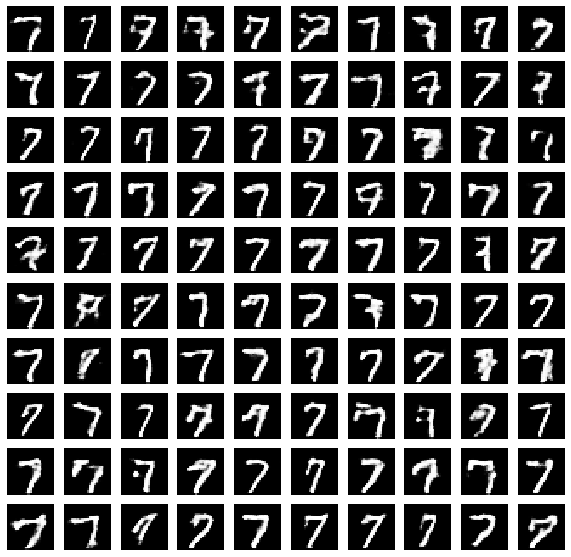

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
vectors = np.random.uniform(-1, 1, size=[100,100])
images = generator.predict(vectors)

plt.figure(figsize=[10,10])
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.axis('off')